https://github.com/Amir-Hofo

# Library

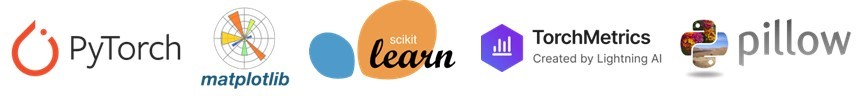

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
import os
from PIL import Image
from torchvision import transforms as T 
from torchvision.utils import make_grid

# Data

## Download Dataset

total size: 1.24 GB

you only need to download the data related to the train.

<div style="font-size: 20px;">
    <a href="https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia">dataset link</a><br>
</div>

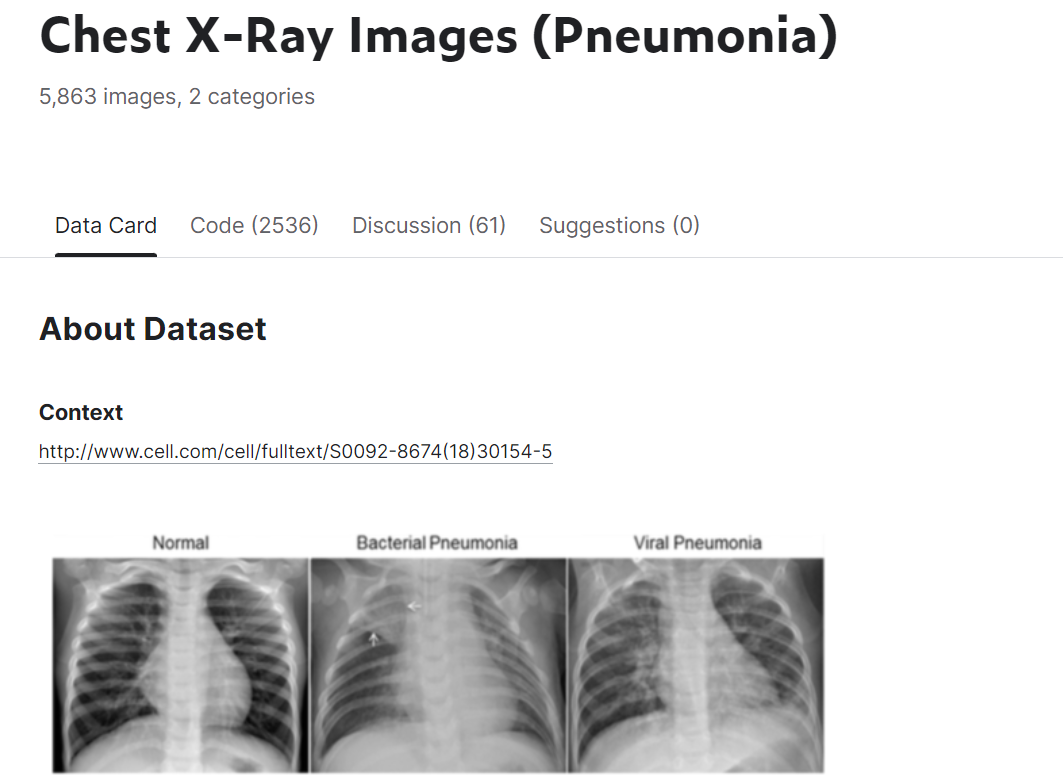

## Processing

replace the "path" with the actual path to your extracted data file.


If you are working with a CPU, replace 'cuda' with 'cpu' for the "device".

torch.Size([64, 1, 250, 250]) torch.Size([64])


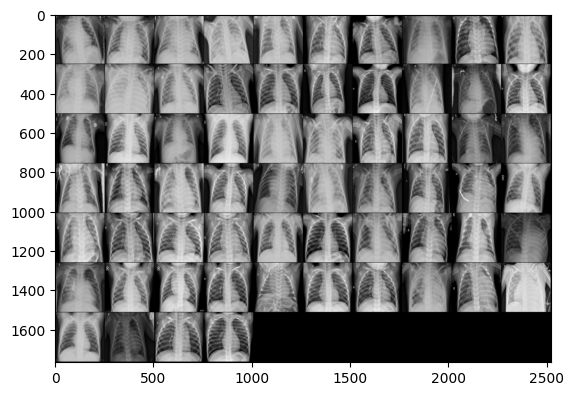

In [2]:
device= 'cuda'
path= r"./chest_xray"
image_size= (250, 250)

def load_data_fn(path):
    folder_path = path
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]
    images_tensor = []
    transform = T.Compose([T.Resize(image_size), 
                            T.ToTensor() ])

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        image_tensor = transform(image)
        if image_tensor.shape[0]==1:
            images_tensor.append(image_tensor)

    images_tensor = torch.stack(images_tensor)
    return images_tensor

images_norm_train= load_data_fn(path+ r"\train\NORMAL")
images_bavi_train= load_data_fn(path+ r"\train\PNEUMONIA")

train_norm_label= torch.zeros(images_norm_train.shape[0], dtype=torch.long)
train_bavi_label= torch.ones(images_bavi_train.shape[0], dtype=torch.long)
train_label= torch.cat((train_norm_label,train_bavi_label))
train_data= torch.cat((images_norm_train, images_bavi_train),dim=0)
del images_norm_train,images_bavi_train, train_norm_label,train_bavi_label

ratio= 0.7
train_data, x_test_raw, train_label, y_test_raw= train_test_split(train_data, train_label,
                                                                  train_size= ratio)
test_data, valid_data, test_label, valid_label= train_test_split(x_test_raw, y_test_raw, 
                                                                 train_size= ratio)

data_batch_size= 64
train_dataset= TensorDataset(train_data,train_label)
del train_data,train_label
valid_dataset= TensorDataset(valid_data,valid_label)
del valid_data,valid_label
test_dataset= TensorDataset(test_data,test_label)
del test_data,test_label
train_loader= DataLoader(train_dataset, 
                         batch_size= data_batch_size, 
                         shuffle=True)
del train_dataset
valid_loader= DataLoader(valid_dataset, 
                         batch_size= data_batch_size, 
                         shuffle=True)
del valid_dataset
test_loader= DataLoader(test_dataset, 
                         batch_size= data_batch_size, 
                         shuffle=True)
del test_dataset

x,y = next(iter(train_loader))
img_grid= make_grid(x, 10)
plt.imshow(img_grid.permute(1,2,0))
print(x.shape, y.shape)

# Model

In [3]:
num_class= 2
num_input= x.shape[1]
width= x.shape[2]
length= x.shape[3]
window= 200
c1= 8
c2= 24
c3= c2
K= round((length-50)/10)
kernel_1= (K,round(window/2))
kernel_2= (width, K)  
kernel_3= (1, 1)
kp_1= (1,4)
kp_2= (1,8)
drop_rate= 0.1
ks0= int(round((kernel_1[0]-1)/2))
ks1= int(round((kernel_1[1]-1)/2))
kernelpad= (ks0, ks1-1)

class custum_model(nn.Module): 
    def __init__(self):
        super().__init__()
        self.af= nn.ELU()
        self.drop= nn.Dropout2d(drop_rate)
        self.conv1= nn.Conv2d(num_input, c1, kernel_1, padding= kernelpad)
        self.batch_1= nn.BatchNorm2d(c1)
        self.conv2= nn.Conv2d(c1, c2, kernel_2, groups= c1)
        self.batch_2= nn.BatchNorm2d(c2)
        self.pool_1= nn.AvgPool2d(kp_1)
        self.conv3= nn.Conv2d(c2, c3, kernel_3)
        self.batch_3= nn.BatchNorm2d(c3)
        self.pool_2= nn.AvgPool2d(kp_2)
        self.fc1= nn.Flatten()
        self.fc2= nn.Linear(336, num_class)
        self.fc3= nn. Softmax(dim= 1)
        
    def forward(self, x):
        x = self.batch_1(self.conv1(x))
        x = self.batch_2(self.conv2(x))
        x = self.af(x)
        x = self.drop(self.pool_1(x))
        x = self.batch_3(self.conv3(x))
        x = self.af(x)
        x = self.drop(self.pool_2(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = custum_model().to(device)
print(model)

custum_model(
  (af): ELU(alpha=1.0)
  (drop): Dropout2d(p=0.1, inplace=False)
  (conv1): Conv2d(1, 8, kernel_size=(20, 100), stride=(1, 1), padding=(10, 49))
  (batch_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 24, kernel_size=(250, 20), stride=(1, 1), groups=8)
  (batch_2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (conv3): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1))
  (batch_3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (fc1): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=336, out_features=2, bias=True)
  (fc3): Softmax(dim=1)
)


# Training

train: 0.945, valid: 0.9595, test: 0.9537


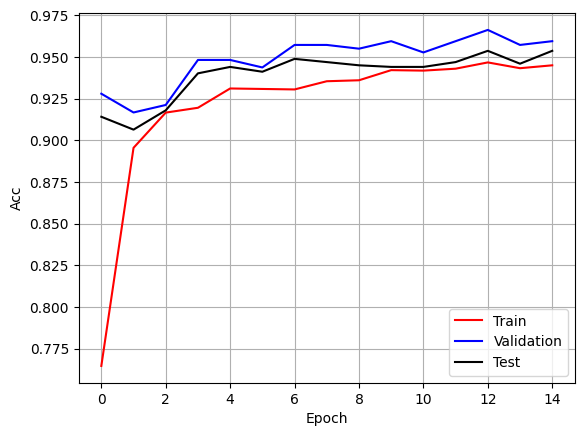

In [4]:
eta= 0.00001
loss_fn= nn.CrossEntropyLoss().to(device)
optimizer= optim.NAdam(model.parameters(), lr= eta)
del x,y

class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class).to(device)
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()
        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
    return model, loss_train.avg, acc_train.compute().item()

def evaluate(model, valid_loader, loss_fn):
    model.eval() 
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes= num_class).to(device)
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss_valid.update(loss.item())
            acc_valid(outputs, targets.int())
    return loss_valid.avg, acc_valid.compute()

num_epochs = 15
loss_train_hist = []
loss_valid_hist = []
loss_test_hist = []
acc_train_hist = []
acc_valid_hist = []
acc_test_hist = []

for epoch in range(num_epochs):
    model, loss_train, acc_train= train_one_epoch(model, train_loader, loss_fn, optimizer)
    loss_valid, acc_valid= evaluate(model, valid_loader, loss_fn)
    loss_test, acc_test= evaluate(model, test_loader, loss_fn)
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    loss_test_hist.append(loss_test)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid.cpu())
    acc_test_hist.append(acc_test.cpu())

print(f'train: {acc_train:.4}, valid: {acc_valid:.4}, test: {acc_test:.4}')
plt.plot(acc_train_hist, 'r-', label='Train')
plt.plot(acc_valid_hist, 'b-', label='Validation')
plt.plot(acc_test_hist, 'k-', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()